I wanted to percieve the popularity of champions in the League of Legends subreddit. First, I decided to carry out a simple frequency based approach.

In [38]:
import praw

reddit = praw.Reddit(client_id='****************',
                     client_secret='**********',
                     user_agent='**************',
                     username='***********',
                     password='*********')


Having initialized the Reddit instance using PRAW( The Python Reddit API Wrapper), I should now open the League of Legends subreddit (r/leagueoflegends). After that, I'll collect the top 500 posts for the past month and all off the sub comments. I've decided to only go 5 layers deep into the comments to make computations faster.

In [40]:
subreddit = reddit.subreddit('leagueoflegends')
file = open('lol_dump.txt', 'w+')
for i in subreddit.top(time_filter = 'month', limit = 500):
    try:
        file.write(i.title)
    except:
        n = 1
    i.comments.replace_more(limit=5)
    comment_queue = i.comments[:]  # Seed with top-level
    while comment_queue:
        comment = comment_queue.pop(0)
        try:
            file.write(comment.body.lower())
            file.write('\n')
        except:
            n = 1
        comment_queue.extend(comment.replies)

file.close()

Now, I'll scrape all of the names of the different champions and make a list.

In [68]:
import bs4
import requests
url = "https://app.mobalytics.gg/champions"
page = requests.get(url)
soup = bs4.BeautifulSoup(page.content, 'lxml')
raw = soup.find_all(name='div', attrs={'class':'champion-infostyles__ChampionName-sc-13d2o0k-1 gJhcAt'})
t = []
for i in raw:
    t.append(i.text.lower())

    

I should probably add common alternatives used for certain champs. For example, a lot of people will just write Velkoz or Nunu instead of  Vel'Koz and Nunu and Willump respectively. I'll even include MF although that might have quite a bit of noise. Also, since this is a word by word search, for champions with names longer than one word, I'll also introduce one word terms used to refer to them. After adding the nicknames to the list of champions, I'll create a dictionary using this list's elements as keys. 

In [69]:
nicks = ['aurelion','velkoz', 'nunu', 'aurelion', 'a-sol', 'blitz', 'chogath', 'mundo', 'gp', 'jarvan', 'khazix', 'kaisa', 'shyv',
         'kogmaw', 'kog', 'fiddle', 'reksai', 'mf', 'morde', 'heimer', 'cait', 'cassio', 'tf', 'tahm', 'trist', 'xin', 'fortune', 
         'yi', 'lee', 'twisted', 'tris'] 
for i in nicks:
    t.append(i)
t.sort()
s = {}
for i in t:
    s[i] = 0

Now I just need to run a simple search through the aggregated titles and comments.

In [56]:
# load text
file = open('lol_dump.txt', 'r+')
text = file.read()
file.close()
# split into words by white space
words = text.split()
# remove punctuation from each word
import string
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in words]

In [70]:
file = open('lol_dump.txt', 'r+')
for i in stripped:
    if(i in t):
        s[i]+=1
        

Now let's add the nickname ones to their actual names.

In [71]:
s['xin zhao'] = s['xin'] + s['xin zhao']
s['aurelion sol'] = s['aurelion'] + s['a-sol']
s['miss fortune'] = s['mf'] + s['fortune']
s['nunu & willump'] = s['nunu'] 
s['dr. mundo'] = s['mundo'] 
s["vel'koz"] = s['velkoz'] + s["vel'koz"] 
s["kha'zix"] = s['khazix'] + s["kha'zix"]
s["kai'sa"] = s['kaisa'] + s["kai'sa"]
s["rek'sai"] = s["rek'sai"] + s['reksai']
s["cho'gath"] = s["cho'gath"] + s['chogath']
s["kog'maw"] = s["kog'maw"] + s["kogmaw"] + s["kog"]
s['heimerdinger'] = s['heimer'] + s['heimerdinger']
s['cassiopeia'] = s['cassiopeia'] + s['cassio']
s['gangplank'] = s['gangplank'] + s['gp']
s['blitzcrank'] = s['blitz'] + s['blitzcrank']
s['caitlyn'] = s['cait'] + s['caitlyn']
s['fiddlesticks'] = s['fiddle'] + s['fiddlesticks']
s['tristana'] = s['trist'] + s['tris'] + s['tristana']
s['jarvan iv'] = s['jarvan']
s['shyvana'] = s['shyvana'] + s['shyv']
s['mordekaiser'] = s['mordekaiser'] = s['morde']
s['twisted fate'] = s['twisted'] + s['tf']
s['master yi'] = s['yi']
s['tahm kench'] = s['tahm']
s['lee sin'] = s['lee']


Now delete the nicknames from the list.

In [77]:
for i in nicks:
    t.remove(i)

ValueError: list.remove(x): x not in list

In [89]:
y = []
for i in t:
    y.append(s[i])

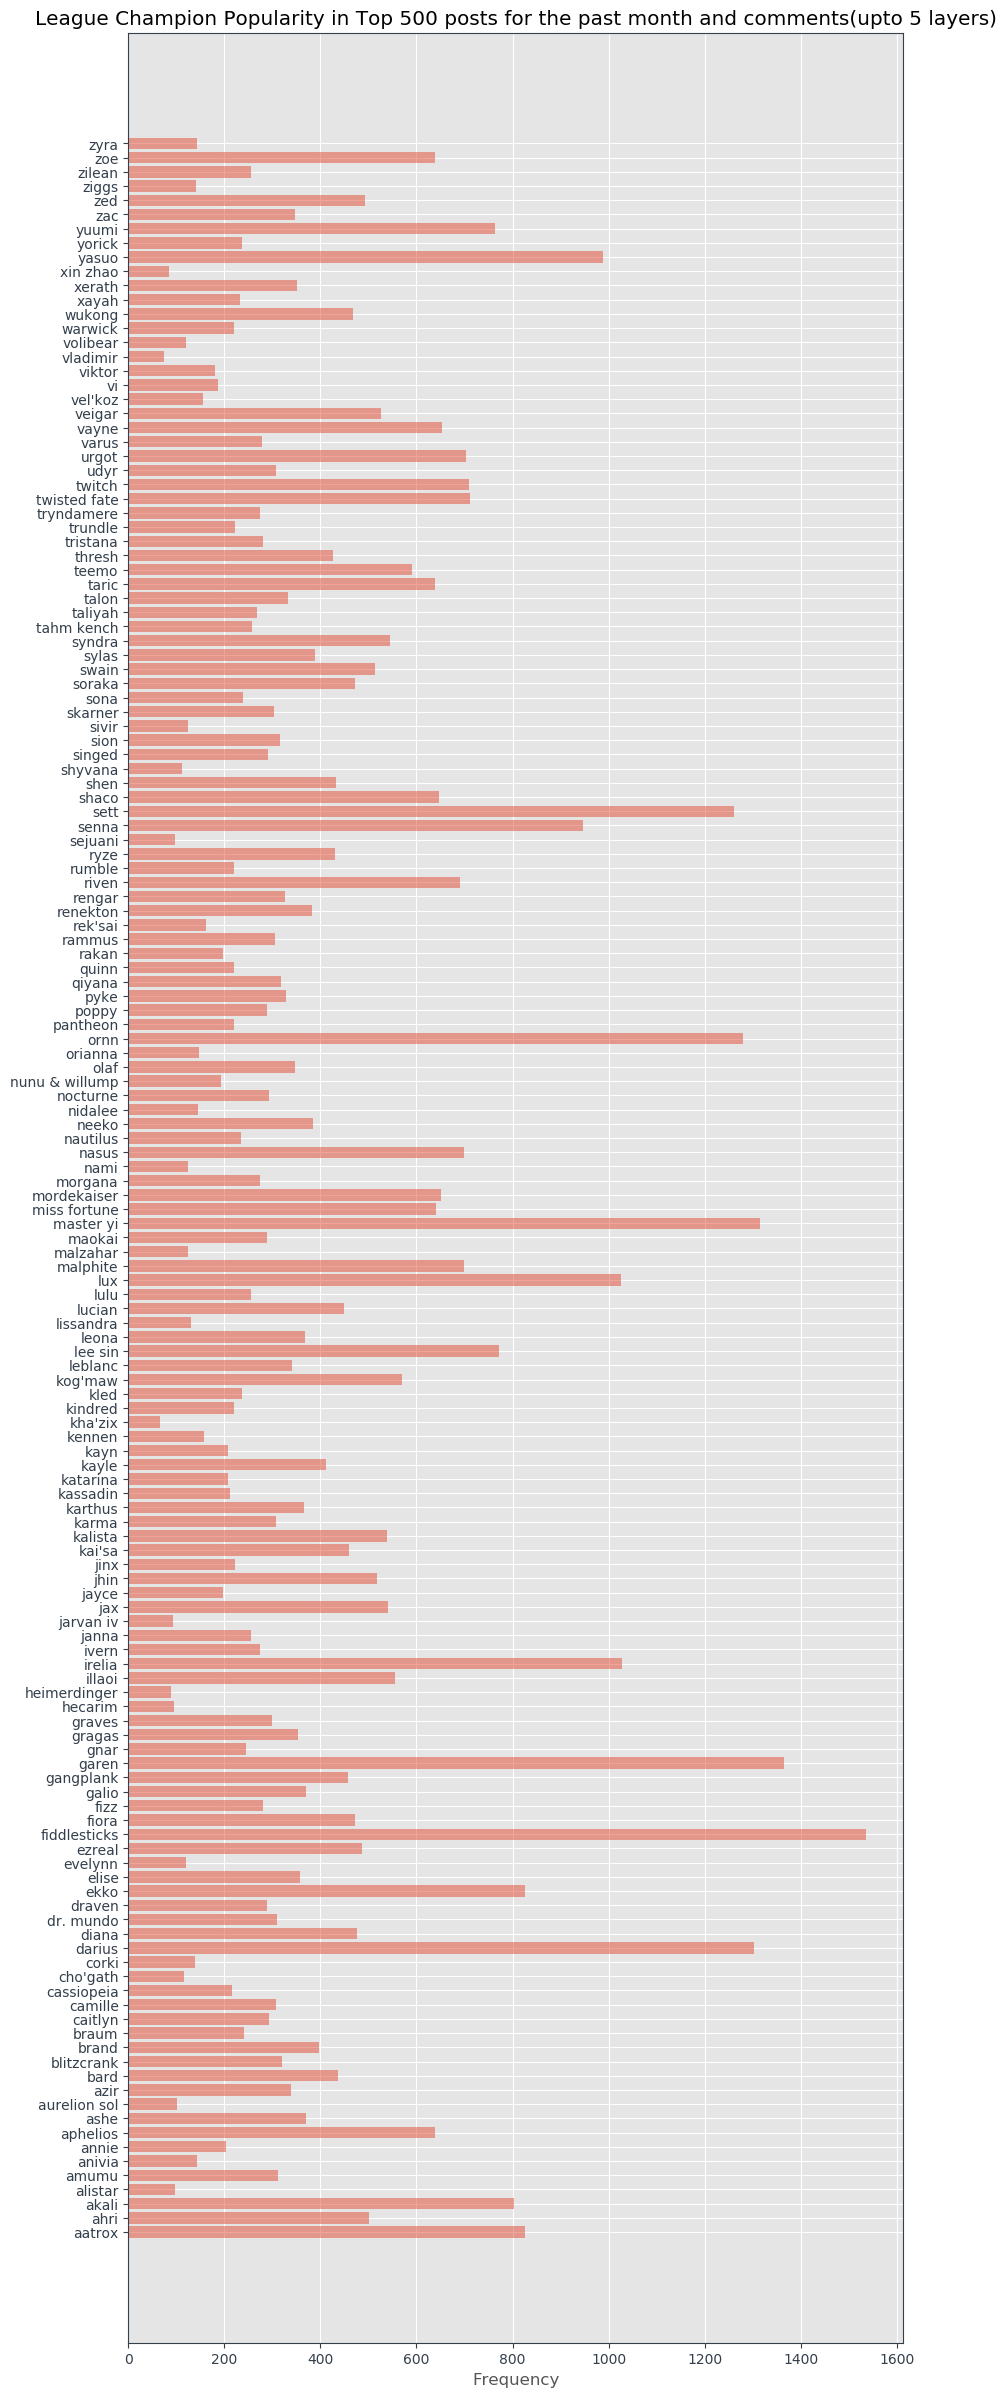

In [109]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = 'Helvetica'



plt.style.use('ggplot')
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.figure(figsize = (10, 30), facecolor = None) 
plt.barh(t, y, align='center', alpha=0.5)

plt.yticks(t)
plt.xlabel('Frequency')
plt.title('League Champion Popularity in Top 500 posts for the past month and comments(upto 5 layers)')

plt.savefig("Champ_freq.jpg")


Aggregating them champion counts by lane, let us see if we see any particular trends. Champions commonly used in multiple lanes will add one point to each lane respectively. Let's whip up a quick Selenium scraper to generate list of champions by lane.

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import NoSuchElementException
import time
FIRE = webdriver.Firefox(executable_path=r"F:\geckodriver.exe")
top = []
jungle = []
mid = []
bot = []
sup = []
with FIRE as driver:
    
    driver.get(url)
    time.sleep(5)
    t = driver.find_element_by_xpath('/html/body/div[2]/div[1]/div/div/div/div[4]/div[2]/div[3]/div[2]/div/div[2]')
    t.click()
    l = soup.find_all(name='div', attrs={'class':'champion-infostyles__ChampionName-sc-13d2o0k-1 gJhcAt'})
    for i in l:
        top.append(i)
        
    t = driver.find_element_by_xpath('/html/body/div[2]/div[1]/div/div/div/div[4]/div[2]/div[3]/div[2]/div/div[3]')
    t.click()
    l = soup.find_all(name='div', attrs={'class':'champion-infostyles__ChampionName-sc-13d2o0k-1 gJhcAt'})
    for i in l:
        jungle.append(i)
        
    t = driver.find_element_by_xpath('/html/body/div[2]/div[1]/div/div/div/div[4]/div[2]/div[3]/div[2]/div/div[4]')
    t.click()
    l = soup.find_all(name='div', attrs={'class':'champion-infostyles__ChampionName-sc-13d2o0k-1 gJhcAt'})
    for i in l:
        mid.append(i)
        
    t = driver.find_element_by_xpath('/html/body/div[2]/div[1]/div/div/div/div[4]/div[2]/div[3]/div[2]/div/div[5]')
    t.click()
    l = soup.find_all(name='div', attrs={'class':'champion-infostyles__ChampionName-sc-13d2o0k-1 gJhcAt'})
    for i in l:
        bot.append(i)
    
    t = driver.find_element_by_xpath('/html/body/div[2]/div[1]/div/div/div/div[4]/div[2]/div[3]/div[2]/div/div[6]')
    t.click()
    l = soup.find_all(name='div', attrs={'class':'champion-infostyles__ChampionName-sc-13d2o0k-1 gJhcAt'})
    for i in l:
        sup.append(i)




    


Let's aggregate the occurrences of these champions on the basis of their class. League has 6 classes: Assassin, Fighter, Marksman, Mage, Support, and Tank

In [ ]:
assassin = ['Akali','Diana','Ekko','Evelynn','Fizz','Kassadin','Katarina',"Kha'Zix",'Nocturne','Pyke','Qiyana','Rengar','Shaco','Talon','Zed']
fighter = []
marksman = []
mage = []
support = []
tank = []
